### 📓 Forecast Open Balances with Prophet (weekly seasonality, year-end spikes, changepoints)

Goals:
- cleans & validates your daily time series,
- explores weekly seasonality,
- encodes Dec–Jan spikes as “holiday” effects,
- tunes changepoints,
- produces an actionable forecast with confidence intervals, and
- visualise/exports results

#### Environment & installs

In [9]:
# If running on a fresh environment, uncomment the next line:
%pip install prophet pandas matplotlib openpyxl


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Parameters & paths

In [10]:
import pathlib

# === USER SETTINGS ===
# Point to your source file(s). You can use either the TXT you exported from Excel or the original Excel file.
TXT_PATH   = pathlib.Path("forecast.txt")       # your uploaded TXT (tab/irregular-delimited)
EXCEL_PATH = pathlib.Path("forecast.xlsx")      # optional: the original Excel, if you have it locally

# Which source to use first? We'll try TXT then Excel.
PREFER_TXT = True

# Forecast horizon (days into the future):
FORECAST_DAYS = 180

# Validation window: use last N days for out-of-sample evaluation
VALIDATION_DAYS = 90

# Prophet flexibility (how much the trend is allowed to bend at changepoints).
# We'll later tune this, but a reasonable starting point is 0.1–0.5
CHANGEPOINT_PRIOR_SCALE = 0.2

# We believe week-level seasonality exists; yearly is weak/unstable
USE_WEEKLY = True
USE_YEARLY = False  # we will model year-end spikes as "holidays" instead of global yearly seasonality

# Year-end spike window (days relative to the dates we declare as 'events')
HOLIDAY_LOWER_WINDOW = -7   # include a week before
HOLIDAY_UPPER_WINDOW = 14   # and 2 weeks after

#### Load & clean the data (robust to “messy” TXT)
We only need 2 columns for Prophet:
- ds → date
- y → value (Open Balances)

The loader below:
- attempts to parse the TXT with flexible delimiters,
- falls back to Excel if TXT isn’t available,
- hunts for the Date column and the Open Balances column even if there are extra/duplicated columns

In [14]:
import pandas as pd
import numpy as np

def load_time_series(txt_path: pathlib.Path, excel_path: pathlib.Path, prefer_txt=True) -> pd.DataFrame:
    """
    Returns a tidy daily dataframe with columns: ds (datetime), y (Open Balances).
    Tries TXT first (very tolerant), then Excel.
    """
    def _coerce_date(s):
        try:
            return pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
        except Exception:
            return pd.to_datetime(s, errors="coerce")
    
    df_raw = None
    errors = []
    
    # --- 1) Try TXT ---
    if prefer_txt and txt_path.exists():
        try:
            df_raw = pd.read_csv(
                txt_path,
                sep=None,        # auto-detect delimiter
                engine="python", # flexible parsing
                dtype=str
            )
        except Exception as e:
            errors.append(("txt", str(e)))
            df_raw = None
    
    # --- 2) Try Excel if TXT failed ---
    if df_raw is None and excel_path.exists():
        try:
            df_raw = pd.read_excel(excel_path, sheet_name=0, dtype=str)
        except Exception as e:
            errors.append(("excel", str(e)))
            df_raw = None
    
    if df_raw is None:
        raise FileNotFoundError(f"Unable to load data. Errors: {errors}")
    
    # normalize column names
    df_raw.rename(columns={c: str(c).strip().lower() for c in df_raw.columns}, inplace=True)
    
    # find date + open balance columns
    date_candidates = [c for c in df_raw.columns if "date" in c]
    ob_candidates   = [c for c in df_raw.columns if ("open" in c and "balance" in c) or ("open balances" in c)]
    
    if not date_candidates:
        date_candidates = [df_raw.columns[0]]
    if not ob_candidates:
        ob_candidates = [df_raw.columns[1]]  # fallback
    
    date_col = date_candidates[0]
    ob_col   = ob_candidates[0]
    
    df = pd.DataFrame({
        "ds": pd.to_datetime(df_raw[date_col], errors="coerce", infer_datetime_format=True),
        "y" : pd.to_numeric(df_raw[ob_col].astype(str).str.replace(",", "", regex=False), errors="coerce")
    })
    
    df = df.dropna(subset=["ds"]).sort_values("ds")
    df = df[~df["y"].isna()]
    
    # create daily grid (so Prophet can detect weekly seasonality)
    full = pd.DataFrame({"ds": pd.date_range(df.ds.min(), df.ds.max(), freq="D")})
    df = full.merge(df, on="ds", how="left")
    df["y"] = df["y"].interpolate(limit_direction="both")
    
    return df
   
df = load_time_series(TXT_PATH, EXCEL_PATH, prefer_txt=PREFER_TXT)
df.head(10)

/var/folders/yq/3qjkrl0d18z0gk9ym07xxs240000gn/T/ipykernel_9559/3966514811.py:58: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  "ds": pd.to_datetime(df_raw[date_col], errors="coerce", infer_datetime_format=True),
/var/folders/yq/3qjkrl0d18z0gk9ym07xxs240000gn/T/ipykernel_9559/3966514811.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  "ds": pd.to_datetime(df_raw[date_col], errors="coerce", infer_datetime_format=True),


,ds,y
0,2022-01-01,1366.000000
1,2022-01-02,3279.000000
2,2022-01-03,3178.909091
3,2022-01-04,3078.818182
4,2022-01-05,2978.727273
5,2022-01-06,2878.636364
6,2022-01-07,2778.545455
7,2022-01-08,2678.454545
8,2022-01-09,2578.363636
9,2022-01-10,2478.272727


#### Quick sanity checks & simple plot

Date range: 2022-01-01 → 2022-12-01
N rows: 335
Missing y: 0


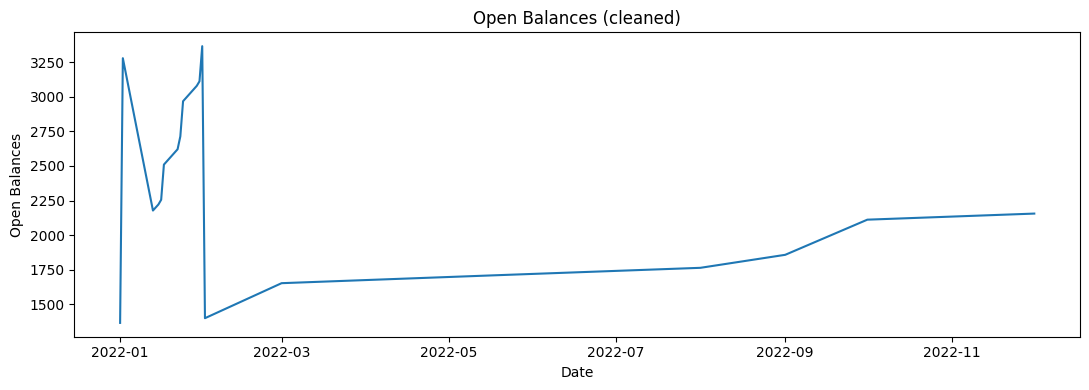

In [15]:
import matplotlib.pyplot as plt

print("Date range:", df["ds"].min().date(), "→", df["ds"].max().date())
print("N rows:", len(df))
print("Missing y:", df["y"].isna().sum())

plt.figure(figsize=(11, 4))
plt.plot(df["ds"], df["y"])
plt.title("Open Balances (cleaned)")
plt.xlabel("Date")
plt.ylabel("Open Balances")
plt.tight_layout()
plt.show()

#### Create “holiday” features for Dec–Jan spikes (recurring every year)

We encode year-end effects as holidays, not full yearly seasonality.
Prophet then learns a systematic uplift around those windows.

In [16]:
def build_year_end_holidays(df: pd.DataFrame,
                            lower_window=-7,
                            upper_window=14) -> pd.DataFrame:
    years = sorted(set(df["ds"].dt.year))
    # Define a representative anchor date (e.g., Dec 25); the windows handle surrounding days
    anchors = []
    for y in years:
        anchors.append(pd.Timestamp(year=y, month=12, day=20))  # near late-Dec
    holidays = pd.DataFrame({
        "holiday": "year_end_spike",
        "ds": pd.to_datetime(anchors),
        "lower_window": lower_window,
        "upper_window": upper_window
    })
    return holidays

holidays = build_year_end_holidays(df,
                                   lower_window=HOLIDAY_LOWER_WINDOW,
                                   upper_window=HOLIDAY_UPPER_WINDOW)
holidays

,holiday,ds,lower_window,upper_window
0,year_end_spike,2022-12-20,-7,14


#### Train/validation split

We simulate a “validation” period by holding out the last VALIDATION_DAYS.
This lets us check whether weekly seasonality + holidays + changepoints generalize.

In [17]:
cutoff_date = df["ds"].max() - pd.Timedelta(days=VALIDATION_DAYS)
df_train = df[df["ds"] <= cutoff_date].copy()
df_valid = df[df["ds"]  > cutoff_date].copy()

print("Train:", df_train["ds"].min().date(), "→", df_train["ds"].max().date(), "(", len(df_train), "rows )")
print("Valid:", df_valid["ds"].min().date(), "→", df_valid["ds"].max().date(), "(", len(df_valid), "rows )")

Train: 2022-01-01 → 2022-09-02 ( 245 rows )
Valid: 2022-09-03 → 2022-12-01 ( 90 rows )


#### Fit a baseline Prophet (weekly seasonality, no yearly)

In [18]:
from prophet import Prophet

m_base = Prophet(
    weekly_seasonality=USE_WEEKLY,
    yearly_seasonality=USE_YEARLY,
    daily_seasonality=False,
    holidays=holidays,
    changepoint_prior_scale=CHANGEPOINT_PRIOR_SCALE,  # modest flexibility
    seasonality_mode="additive"  # balances are absolute; additive is typical
)

m_base.fit(df_train)

future_valid = m_base.make_future_dataframe(periods=len(df_valid), freq="D")
fc_valid = m_base.predict(future_valid)

/Users/phoebeneo/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
18:56:03 - cmdstanpy - INFO - Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing


#### Plot components (trend, weekly, holidays):

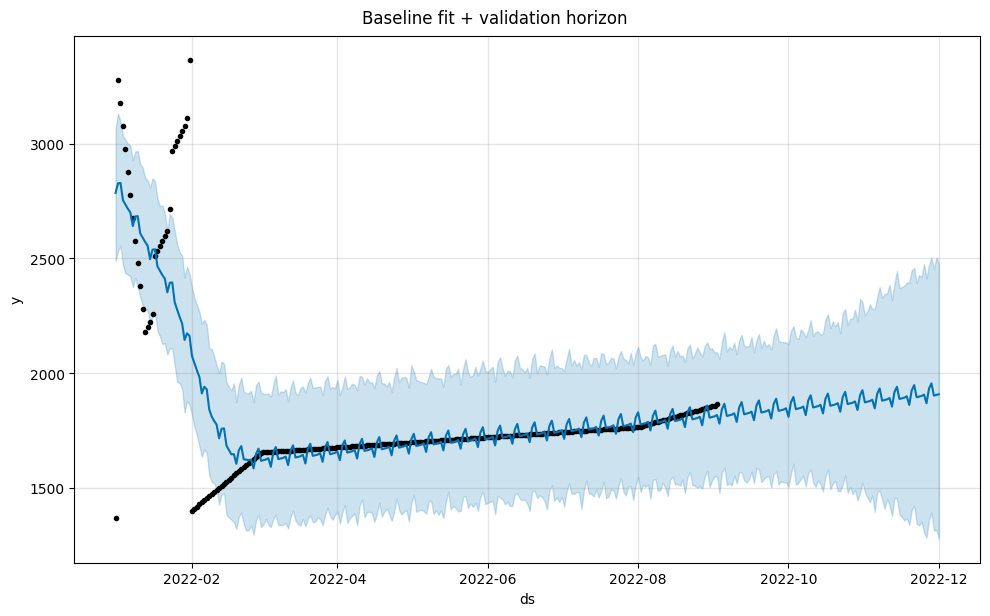

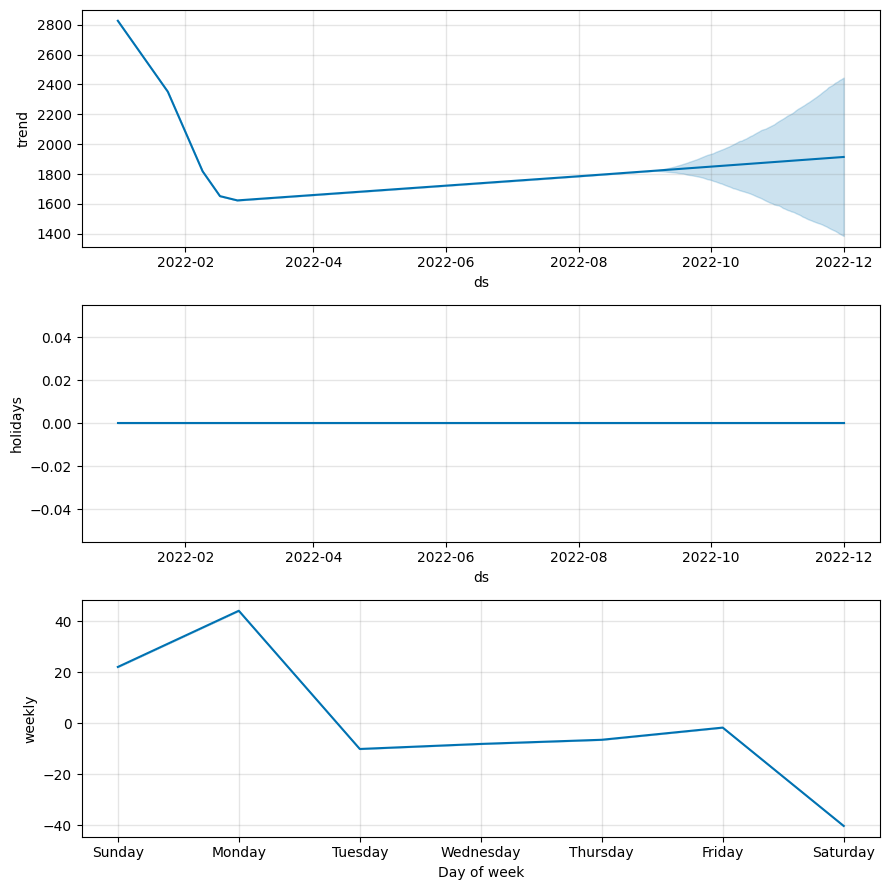

In [19]:
fig1 = m_base.plot(fc_valid)
fig1.suptitle("Baseline fit + validation horizon", y=1.02)
plt.show()

fig2 = m_base.plot_components(fc_valid)
plt.show()

#### Evaluate on validation (MAE/MAPE/RMSE)

Validation MAE : 221.87
Validation RMSE: 230.19
Validation MAPE: 10.53 %


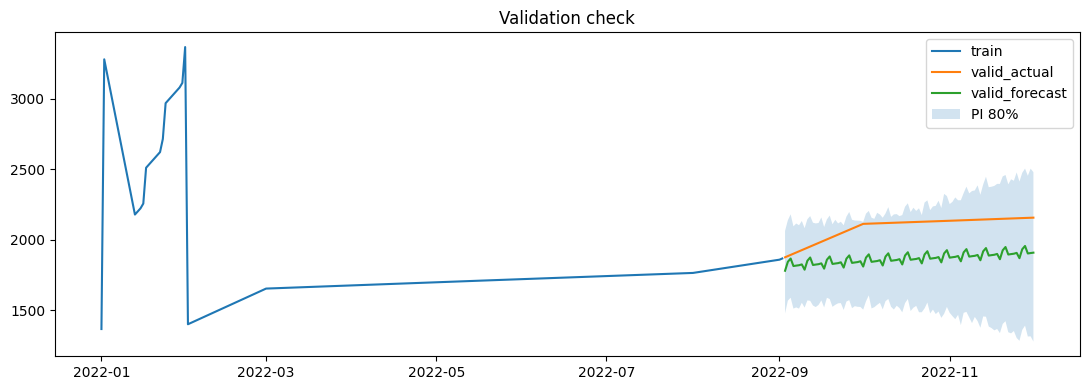

In [20]:
# Merge forecast with actuals
eval_df = df_valid.merge(fc_valid[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds", how="left")

def mae(a, f):  return np.mean(np.abs(a-f))
def rmse(a, f): return np.sqrt(np.mean((a-f)**2))
def mape(a, f):
    a = np.array(a); f = np.array(f)
    mask = a != 0
    return np.mean(np.abs((a[mask]-f[mask])/a[mask]))*100

print("Validation MAE :", round(mae(eval_df['y'], eval_df['yhat']), 2))
print("Validation RMSE:", round(rmse(eval_df['y'], eval_df['yhat']), 2))
print("Validation MAPE:", round(mape(eval_df['y'], eval_df['yhat']), 2), "%")

plt.figure(figsize=(11,4))
plt.plot(df_train["ds"], df_train["y"], label="train")
plt.plot(df_valid["ds"], df_valid["y"], label="valid_actual")
plt.plot(eval_df["ds"], eval_df["yhat"], label="valid_forecast")
plt.fill_between(eval_df["ds"], eval_df["yhat_lower"], eval_df["yhat_upper"], alpha=0.2, label="PI 80%")
plt.title("Validation check")
plt.legend()
plt.tight_layout()
plt.show()

#### Changepoint tuning (simple grid search)
Prophet’s performance depends a lot on changepoint_prior_scale.
We’ll try a small grid and keep the one with the lowest validation MAE.

In [21]:
cps_grid = [0.05, 0.1, 0.2, 0.3, 0.5]
results = []

for cps in cps_grid:
    m = Prophet(
        weekly_seasonality=USE_WEEKLY,
        yearly_seasonality=USE_YEARLY,
        daily_seasonality=False,
        holidays=holidays,
        changepoint_prior_scale=cps,
        seasonality_mode="additive",
    )
    m.fit(df_train)
    f = m.predict(m.make_future_dataframe(periods=len(df_valid), freq="D"))
    tmp = df_valid.merge(f[["ds","yhat"]], on="ds", how="left")
    results.append({
        "cps": cps,
        "MAE": mae(tmp["y"], tmp["yhat"]),
        "RMSE": rmse(tmp["y"], tmp["yhat"]),
        "MAPE": mape(tmp["y"], tmp["yhat"])
    })

grid_df = pd.DataFrame(results).sort_values("MAE")
grid_df

# pick the best CPS
best_cps = grid_df.iloc[0]["cps"]
print("Best changepoint_prior_scale:", best_cps)

18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing


Best changepoint_prior_scale: 0.5


#### Refit on ALL data with best settings, then forecast future

In [22]:
m_final = Prophet(
    weekly_seasonality=USE_WEEKLY,
    yearly_seasonality=USE_YEARLY,
    daily_seasonality=False,
    holidays=holidays,
    changepoint_prior_scale=float(best_cps),
    seasonality_mode="additive",
)

m_final.fit(df)

future = m_final.make_future_dataframe(periods=FORECAST_DAYS, freq="D")
forecast = m_final.predict(future)

# Save useful output
out = forecast[["ds","yhat","yhat_lower","yhat_upper"]]\
      .merge(df[["ds","y"]], on="ds", how="left")

out_tail = out.tail(FORECAST_DAYS)
out_tail.head(10)

18:56:21 - cmdstanpy - INFO - Chain [1] start processing
18:56:21 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y
335,2022-12-02,2183.834750,1952.927728,2394.298506,NaN
336,2022-12-03,2162.005546,1923.728006,2388.444461,NaN
337,2022-12-04,2209.476419,1989.082544,2455.118570,NaN
338,2022-12-05,2226.556231,1994.122940,2437.078944,NaN
339,2022-12-06,2187.767996,1956.043607,2417.760486,NaN
340,2022-12-07,2189.951096,1964.208930,2427.859540,NaN
341,2022-12-08,2192.070072,1952.458956,2411.233660,NaN
342,2022-12-09,2197.461427,1972.717738,2417.587497,NaN
343,2022-12-10,2175.632223,1945.102877,2383.340270,NaN
344,2022-12-11,2223.103095,1992.619800,2472.732839,NaN


#### Final plots

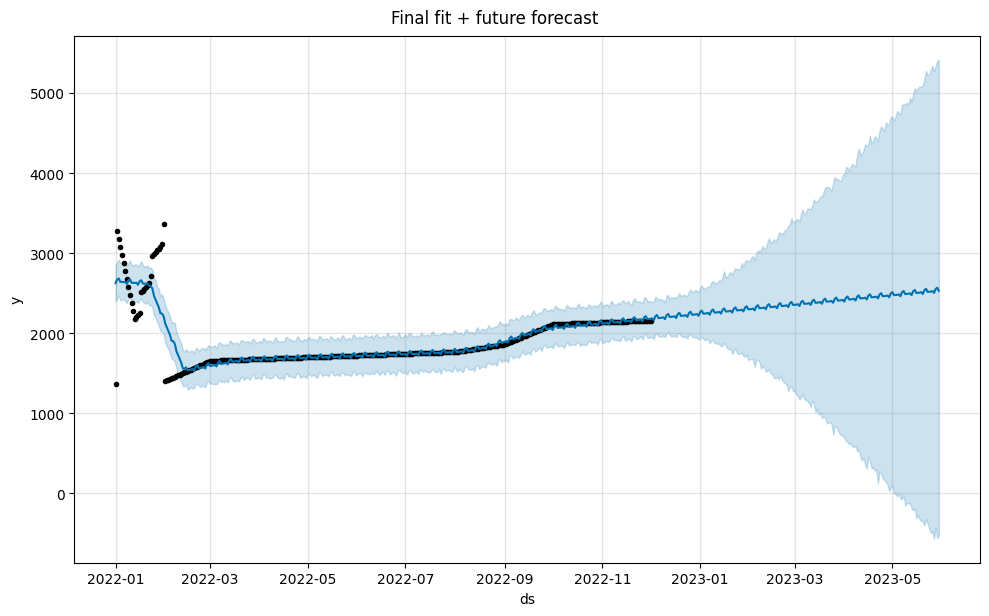

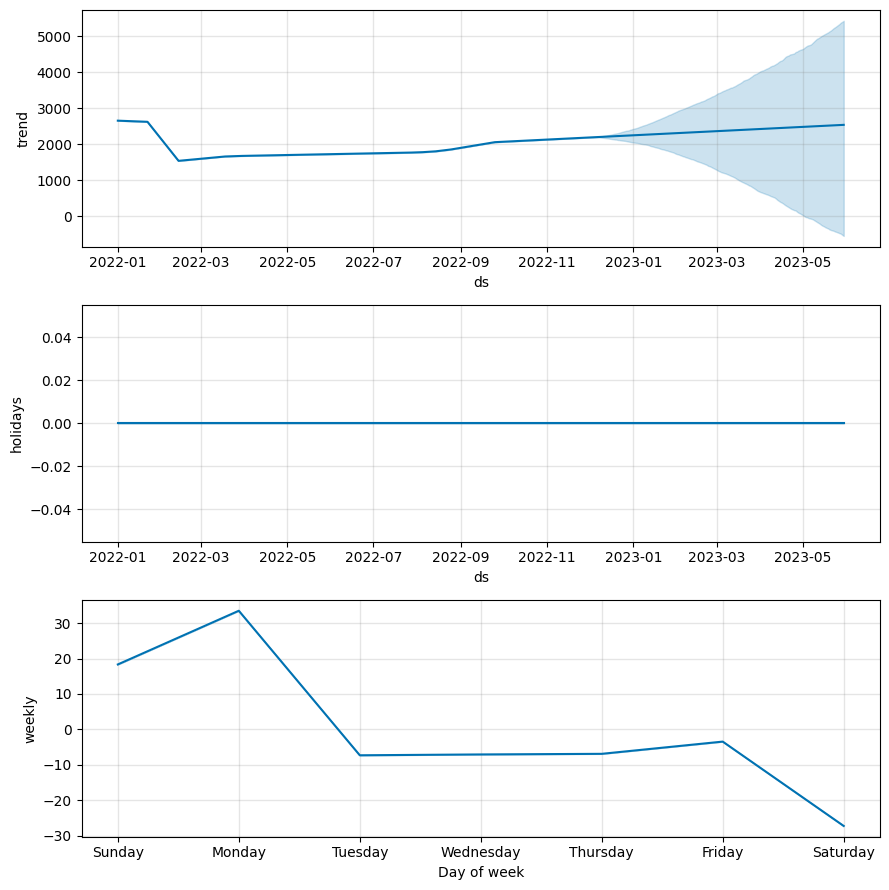

In [23]:
fig = m_final.plot(forecast)
fig.suptitle("Final fit + future forecast", y=1.02)
plt.show()

m_final.plot_components(forecast)
plt.show()

#### Scenario tweaking (optional): “what if” the weekly profile changes?

Superimpose trend and experiment by:
- switching seasonality_mode="multiplicative" if spikes scale with level, or
- adding an extra custom weekly seasonality component (e.g., stronger Mondays).""

18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing


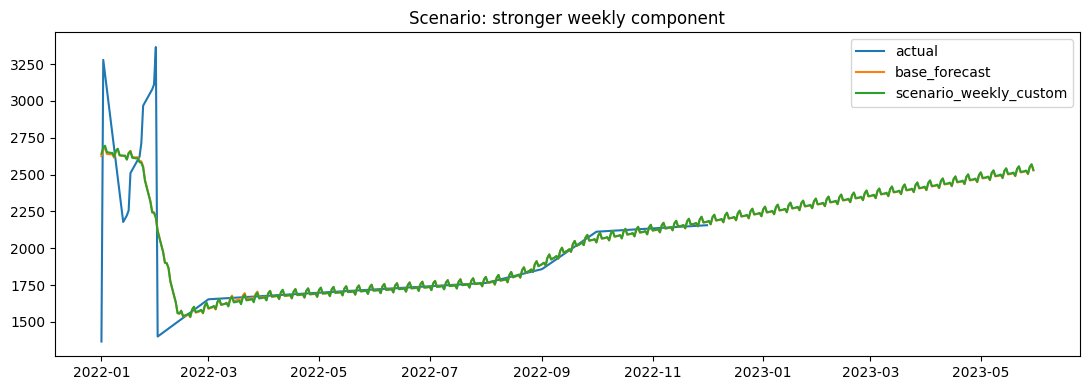

In [24]:
m_scn = Prophet(
    weekly_seasonality=False,     # turn off default
    yearly_seasonality=USE_YEARLY,
    daily_seasonality=False,
    holidays=holidays,
    changepoint_prior_scale=float(best_cps),
    seasonality_mode="additive",
)
# Explicit weekly with stronger regularization control
m_scn.add_seasonality(name='weekly_custom', period=7, fourier_order=6, prior_scale=10)

m_scn.fit(df)
f_scn = m_scn.predict(m_scn.make_future_dataframe(periods=FORECAST_DAYS, freq="D"))

plt.figure(figsize=(11,4))
plt.plot(out["ds"], out["y"], label="actual")
plt.plot(forecast["ds"], forecast["yhat"], label="base_forecast")
plt.plot(f_scn["ds"], f_scn["yhat"], label="scenario_weekly_custom")
plt.title("Scenario: stronger weekly component")
plt.legend()
plt.tight_layout()
plt.show()

#### Export forecast to files

In [ ]:
out.to_csv("open_balances_forecast_full.csv", index=False)
out_tail.to_csv("open_balances_forecast_next_{}_days.csv".format(FORECAST_DAYS), index=False)
print("Saved: open_balances_forecast_full.csv and open_balances_forecast_next_{}_days.csv".format(FORECAST_DAYS))

#### Notes, pitfalls & next steps

##### What worked here
- We avoided yearly seasonality (which your series doesn’t show clearly) and instead used holiday windows around Dec–Jan.
- We tuned changepoints to better capture medium-term shifts.
- We validated using a time-based holdout (last 90 days).

##### What to watch out for
- If business processes changed (policy, staffing), you may need regressors:
  - e.g., number of agents (capacity), SLAs, promotion events that change incoming cases
  - Add them with add_regressor(...) once you have daily history for those signals.
- If spikes vary with the level of the series, try seasonality_mode="multiplicative" in the final model and re-evaluate.
- If your TXT is very messy, double-check the loader identified the right columns (print df.head() after loading).

##### Recommended extensions
- Build a feature calendar (public holidays, org blackout periods, monthly closings).
- Track MAPE/MAE each month to see if weekly seasonality remains stable.
- If you want “confidence-weighted” capacity planning, use Prophet’s prediction interval (yhat_lower/upper) and plan for the 80–90th percentile.

#### TL;DR modeling choices (and why)
- Weekly seasonality: business processes usually have weekday/weekend effects → yes.
- Yearly seasonality: weak, inconsistent → avoid; encode December–January via holidays instead.
- Changepoints: allow trend to bend; tune changepoint_prior_scale by validation.
- Additive seasonality: balances are absolute counts; start additive; switch to multiplicative only if error clearly drops.